### Import the necessary libraries

In [49]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Load the training data from train.csv file

In [50]:
trainds= pd.read_csv("train_labels.csv")


### Print the shape of the train dataset

In [51]:
len(trainds)

173

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [56]:
# SETTINGS

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

TRAIN_CSV = "train_labels.csv"


trainds.drop('class', axis=1)  
trainds.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [62]:
import csv
from PIL import Image
paths = []
coords = np.zeros((trainds.shape[0], 4))
for i in range(len(trainds)):
     path = "/home/raj/Downloads/chennai-aug-batch-mraj2018/DL/Lab-Internal-AdvancedCNN-R9/images/" + trainds.iloc[i,0]
     image_width = trainds.iloc[i,1]
     image_height = trainds.iloc[i,2]
     x0 = trainds.iloc[i,4]
     y0 = trainds.iloc[i,5]
     x1 = trainds.iloc[i,6]
     y1 = trainds.iloc[i,7]
     coords[i, 0] =  x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
     coords[i, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
     coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
     coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height
     paths.append(path)


### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [64]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [65]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

17227776/17225924 [==============================] - 24s 1us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [66]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [80]:
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

Epoch 1/30
173/173 [==============================] - 8s 45ms/step - loss: 147.8207 - IoU: 0.6934
Epoch 2/30
173/173 [==============================] - 7s 42ms/step - loss: 108.5008 - IoU: 0.7445
Epoch 3/30
173/173 [==============================] - 7s 43ms/step - loss: 88.9149 - IoU: 0.7505
Epoch 4/30
173/173 [==============================] - 7s 41ms/step - loss: 80.5437 - IoU: 0.7757
Epoch 5/30
173/173 [==============================] - 7s 41ms/step - loss: 72.1149 - IoU: 0.7956
Epoch 6/30
173/173 [==============================] - 7s 40ms/step - loss: 69.1049 - IoU: 0.8025
Epoch 7/30
173/173 [==============================] - 7s 42ms/step - loss: 63.7478 - IoU: 0.8162
Epoch 8/30
173/173 [==============================] - 7s 40ms/step - loss: 61.3603 - IoU: 0.8304
Epoch 9/30
173/173 [==============================] - 7s 39ms/step - loss: 64.5119 - IoU: 0.8271
Epoch 10/30
173/173 [==============================] - 7s 39ms/step - loss: 59.6704 - IoU: 0.8342
Epoch 11/30
173/173 [======

### Pick a test image from the given data

In [86]:
import cv2
filename = '/home/raj/Downloads/chennai-aug-batch-mraj2018/DL/Lab-Internal-AdvancedCNN-R9/images/raccoon-105.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [87]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [88]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

In [89]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

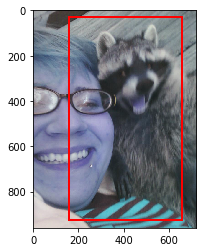

In [90]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## Problem 2 : Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

In [0]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

#### Mount google drive

### Load the  data file

            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


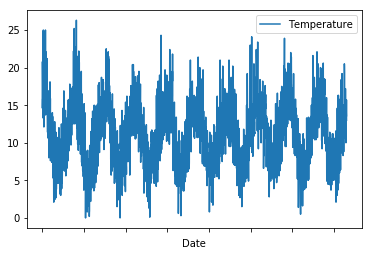

In [91]:
df = pd.read_csv('daily-minimum-temperatures-in-me.csv', index_col='Date')
print(df.head())


### Plot the data

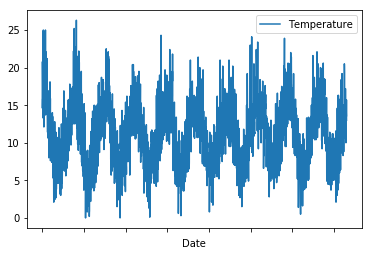

In [92]:
df.plot()

### Check for null values and treat them

In [96]:
df.isnull().sum()

Temperature    0
dtype: int64

#### Drop null values (if any)

In [0]:
# nothing to drop

### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a9d4e16d8>]],
      dtype=object)

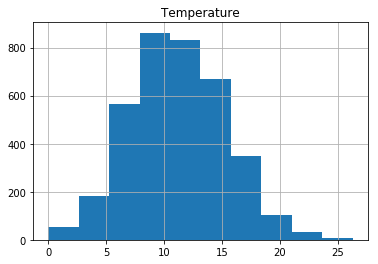

In [97]:
df.hist(bins=10)

### Check the maximum and minimum values

In [101]:
# Scaled Data
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [102]:
dataset = df.astype('float32')

### Check the maximum and minimum values of scaled data

In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

/home/raj/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [105]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [106]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [107]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

Y 446
0.5931559252475964
446
X 446 to 447
[0.59315593]
Y 447
0.5019011479918374
447
X 447 to 448
[0.50190115]
Y 448
0.5513308144727008
448
X 448 to 449
[0.55133081]
Y 449
0.638783259483403
449
X 449 to 450
[0.63878326]
Y 450
0.6539924434181024
450
X 450 to 451
[0.65399244]
Y 451
0.5095057036978052
451
X 451 to 452
[0.5095057]
Y 452
0.5399239627830582
452
X 452 to 453
[0.53992396]
Y 453
0.543726258766733
453
X 453 to 454
[0.54372626]
Y 454
0.3878327036181752
454
X 454 to 455
[0.3878327]
Y 455
0.395437259324143
455
X 455 to 456
[0.39543726]
Y 456
0.46768062918429154
456
X 456 to 457
[0.46768063]
Y 457
0.4524714815109741
457
X 457 to 458
[0.45247148]
Y 458
0.42585551840939595
458
X 458 to 459
[0.42585552]
Y 459
0.3231939257253763
459
X 459 to 460
[0.32319393]
Y 460
0.4562737774946489
460
X 460 to 461
[0.45627378]
Y 461
0.47148288890658446
461
X 461 to 462
[0.47148289]
Y 462
0.4904942963021948
462
X 462 to 463
[0.4904943]
Y 463
0.38403044389588226
463
X 463 to 464
[0.38403044]
Y 464
0.5703

0.5171102956651549
673
X 673 to 674
[0.5171103]
Y 674
0.6730038508137127
674
X 674 to 675
[0.67300385]
Y 675
0.6083650366595319
675
X 675 to 676
[0.60836504]
Y 676
0.42965781439307077
676
X 676 to 677
[0.42965781]
Y 677
0.3992395553078178
677
X 677 to 678
[0.39923956]
Y 678
0.547528518489026
678
X 678 to 679
[0.54752852]
Y 679
0.39163499960185005
679
X 679 to 680
[0.391635]
Y 680
0.34220533312098667
680
X 680 to 681
[0.34220533]
Y 681
0.42205325868710303
681
X 681 to 682
[0.42205326]
Y 682
0.5513308144727008
682
X 682 to 683
[0.55133081]
Y 683
0.6844106662419733
683
X 683 to 684
[0.68441067]
Y 684
0.4866920365799019
684
X 684 to 685
[0.48669204]
Y 685
0.4068441110137856
685
X 685 to 686
[0.40684411]
Y 686
0.34600762910466154
686
X 686 to 687
[0.34600763]
Y 687
0.3307984814313441
687
X 687 to 688
[0.33079848]
Y 688
0.47148288890658446
688
X 688 to 689
[0.47148289]
Y 689
0.47908748087393416
689
X 689 to 690
[0.47908748]
Y 690
0.39163499960185005
690
X 690 to 691
[0.391635]
Y 691
0.520912

0.41444866671975333
1073
X 1073 to 1074
[0.41444867]
Y 1074
0.4562737774946489
1074
X 1074 to 1075
[0.45627378]
Y 1075
0.6273764440551423
1075
X 1075 to 1076
[0.62737644]
Y 1076
0.5703422218683112
1076
X 1076 to 1077
[0.57034222]
Y 1077
0.42585551840939595
1077
X 1077 to 1078
[0.42585552]
Y 1078
0.5285171110934156
1078
X 1078 to 1079
[0.52851711]
Y 1079
0.5703422218683112
1079
X 1079 to 1080
[0.57034222]
Y 1080
0.5627376661623434
1080
X 1080 to 1081
[0.56273767]
Y 1081
0.5703422218683112
1081
X 1081 to 1082
[0.57034222]
Y 1082
0.5057034439755123
1082
X 1082 to 1083
[0.50570344]
Y 1083
0.7756654072363504
1083
X 1083 to 1084
[0.77566541]
Y 1084
0.6844106662419733
1084
X 1084 to 1085
[0.68441067]
Y 1085
0.46387833320061667
1085
X 1085 to 1086
[0.46387833]
Y 1086
0.6349810360224919
1086
X 1086 to 1087
[0.63498104]
Y 1087
0.5247148513711226
1087
X 1087 to 1088
[0.52471485]
Y 1088
0.665399258846363
1088
X 1088 to 1089
[0.66539926]
Y 1089
0.5703422218683112
1089
X 1089 to 1090
[0.57034222]
Y 

X 1521 to 1522
[0.55893537]
Y 1522
0.4828897405962271
1522
X 1522 to 1523
[0.48288974]
Y 1523
0.4068441110137856
1523
X 1523 to 1524
[0.40684411]
Y 1524
0.47908748087393416
1524
X 1524 to 1525
[0.47908748]
Y 1525
0.3726235922062397
1525
X 1525 to 1526
[0.37262359]
Y 1526
0.5019011479918374
1526
X 1526 to 1527
[0.50190115]
Y 1527
0.5779467775742789
1527
X 1527 to 1528
[0.57794678]
Y 1528
0.6311787400388171
1528
X 1528 to 1529
[0.63117874]
Y 1529
0.7984791106156356
1529
X 1529 to 1530
[0.79847911]
Y 1530
0.8517110368187919
1530
X 1530 to 1531
[0.85171104]
Y 1531
0.6463878514507526
1531
X 1531 to 1532
[0.64638785]
Y 1532
0.8250951099785957
1532
X 1532 to 1533
[0.82509511]
Y 1533
0.8136882220275712
1533
X 1533 to 1534
[0.81368822]
Y 1534
0.7072243696212586
1534
X 1534 to 1535
[0.70722437]
Y 1535
0.6159696286268815
1535
X 1535 to 1536
[0.61596963]
Y 1536
0.638783259483403
1536
X 1536 to 1537
[0.63878326]
Y 1537
0.6463878514507526
1537
X 1537 to 1538
[0.64638785]
Y 1538
0.6996197776539089
15

Y 1873
0.4828897405962271
1873
X 1873 to 1874
[0.48288974]
Y 1874
0.5247148513711226
1874
X 1874 to 1875
[0.52471485]
Y 1875
0.5323194070770905
1875
X 1875 to 1876
[0.53231941]
Y 1876
0.5703422218683112
1876
X 1876 to 1877
[0.57034222]
Y 1877
0.5513308144727008
1877
X 1877 to 1878
[0.55133081]
Y 1878
0.4980988882695445
1878
X 1878 to 1879
[0.49809889]
Y 1879
0.4334600741153637
1879
X 1879 to 1880
[0.43346007]
Y 1880
0.4752851848902593
1880
X 1880 to 1881
[0.47528518]
Y 1881
0.4562737774946489
1881
X 1881 to 1882
[0.45627378]
Y 1882
0.5095057036978052
1882
X 1882 to 1883
[0.5095057]
Y 1883
0.547528518489026
1883
X 1883 to 1884
[0.54752852]
Y 1884
0.6730038508137127
1884
X 1884 to 1885
[0.67300385]
Y 1885
0.5285171110934156
1885
X 1885 to 1886
[0.52851711]
Y 1886
0.5057034439755123
1886
X 1886 to 1887
[0.50570344]
Y 1887
0.5551331104563756
1887
X 1887 to 1888
[0.55513311]
Y 1888
0.6235741480714674
1888
X 1888 to 1889
[0.62357415]
Y 1889
0.638783259483403
1889
X 1889 to 1890
[0.63878326]


[0.41825096]
Y 2273
0.39163499960185005
2273
X 2273 to 2274
[0.391635]
Y 2274
0.49429659228586964
2274
X 2274 to 2275
[0.49429659]
Y 2275
0.46768062918429154
2275
X 2275 to 2276
[0.46768063]
Y 2276
0.5931559252475964
2276
X 2276 to 2277
[0.59315593]
Y 2277
0.3878327036181752
2277
X 2277 to 2278
[0.3878327]
Y 2278
0.4106464069974604
2278
X 2278 to 2279
[0.41064641]
Y 2279
0.4562737774946489
2279
X 2279 to 2280
[0.45627378]
Y 2280
0.5057034439755123
2280
X 2280 to 2281
[0.50570344]
Y 2281
0.4448669258050063
2281
X 2281 to 2282
[0.44486693]
Y 2282
0.4752851848902593
2282
X 2282 to 2283
[0.47528518]
Y 2283
0.5209125553874479
2283
X 2283 to 2284
[0.52091256]
Y 2284
0.5665399258846363
2284
X 2284 to 2285
[0.56653993]
Y 2285
0.7680608877917645
2285
X 2285 to 2286
[0.76806089]
Y 2286
0.6197718520877926
2286
X 2286 to 2287
[0.61977185]
Y 2287
0.5285171110934156
2287
X 2287 to 2288
[0.52851711]
Y 2288
0.38403044389588226
2288
X 2288 to 2289
[0.38403044]
Y 2289
0.2775665552281878
2289
X 2289 to 2

1095 1
0
X 0 to 1
[0.58174907]
Y 1
0.543726258766733
1
X 1 to 2
[0.54372626]
Y 2
0.51330799968148
2
X 2 to 3
[0.513308]
Y 3
0.5703422218683112
3
X 3 to 4
[0.57034222]
Y 4
0.5171102956651549
4
X 4 to 5
[0.5171103]
Y 5
0.5779467775742789
5
X 5 to 6
[0.57794678]
Y 6
0.6463878514507526
6
X 6 to 7
[0.64638785]
Y 7
0.7110266656049334
7
X 7 to 8
[0.71102667]
Y 8
0.6273764440551423
8
X 8 to 9
[0.62737644]
Y 9
0.6615969628626882
9
X 9 to 10
[0.66159696]
Y 10
0.695817481670234
10
X 10 to 11
[0.69581748]
Y 11
0.695817481670234
11
X 11 to 12
[0.69581748]
Y 12
0.8517110368187919
12
X 12 to 13
[0.85171104]
Y 13
0.8136882220275712
13
X 13 to 14
[0.81368822]
Y 14
0.7946768146319608
14
X 14 to 15
[0.79467681]
Y 15
0.6692015548300378
15
X 15 to 16
[0.66920155]
Y 16
0.5893536292639215
16
X 16 to 17
[0.58935363]
Y 17
0.6311787400388171
17
X 17 to 18
[0.63117874]
Y 18
0.6159696286268815
18
X 18 to 19
[0.61596963]
Y 19
0.5931559252475964
19
X 19 to 20
[0.59315593]
Y 20
0.5513308144727008
20
X 20 to 21
[0.55

[0.54752852]
Y 398
0.6197718520877926
398
X 398 to 399
[0.61977185]
Y 399
0.5969581849698893
399
X 399 to 400
[0.59695818]
Y 400
0.5399239627830582
400
X 400 to 401
[0.53992396]
Y 401
0.5019011479918374
401
X 401 to 402
[0.50190115]
Y 402
0.638783259483403
402
X 402 to 403
[0.63878326]
Y 403
0.7034220736375838
403
X 403 to 404
[0.70342207]
Y 404
0.6349810360224919
404
X 404 to 405
[0.63498104]
Y 405
0.5817490735579538
405
X 405 to 406
[0.58174907]
Y 406
0.604562740675857
406
X 406 to 407
[0.60456274]
Y 407
0.5779467775742789
407
X 407 to 408
[0.57794678]
Y 408
0.665399258846363
408
X 408 to 409
[0.66539926]
Y 409
0.695817481670234
409
X 409 to 410
[0.69581748]
Y 410
0.7376425924451296
410
X 410 to 411
[0.73764259]
Y 411
0.7376425924451296
411
X 411 to 412
[0.73764259]
Y 412
0.7414448884288045
412
X 412 to 413
[0.74144489]
Y 413
0.7794677032200252
413
X 413 to 414
[0.7794677]
Y 414
0.5969581849698893
414
X 414 to 415
[0.59695818]
Y 415
0.5703422218683112
415
X 415 to 416
[0.57034222]
Y 

0.543726258766733
810
X 810 to 811
[0.54372626]
Y 811
0.6083650366595319
811
X 811 to 812
[0.60836504]
Y 812
0.6615969628626882
812
X 812 to 813
[0.66159696]
Y 813
0.6425855554670779
813
X 813 to 814
[0.64258556]
Y 814
0.6844106662419733
814
X 814 to 815
[0.68441067]
Y 815
0.7832699992037001
815
X 815 to 816
[0.78327]
Y 816
0.5399239627830582
816
X 816 to 817
[0.53992396]
Y 817
0.41444866671975333
817
X 817 to 818
[0.41444867]
Y 818
0.4524714815109741
818
X 818 to 819
[0.45247148]
Y 819
0.5057034439755123
819
X 819 to 820
[0.50570344]
Y 820
0.5817490735579538
820
X 820 to 821
[0.58174907]
Y 821
0.5589353701786686
821
X 821 to 822
[0.55893537]
Y 822
0.4182509627034282
822
X 822 to 823
[0.41825096]
Y 823
0.46387833320061667
823
X 823 to 824
[0.46387833]
Y 824
0.5399239627830582
824
X 824 to 825
[0.53992396]
Y 825
0.6463878514507526
825
X 825 to 826
[0.64638785]
Y 826
0.6007604809535642
826
X 826 to 827
[0.60076048]
Y 827
0.5779467775742789
827
X 827 to 828
[0.57794678]
Y 828
0.5741445178

[0.65399244]
Y 1082
0.5589353701786686
1082
X 1082 to 1083
[0.55893537]
Y 1083
0.5855513332802467
1083
X 1083 to 1084
[0.58555133]
Y 1084
0.4980988882695445
1084
X 1084 to 1085
[0.49809889]
Y 1085
0.5019011479918374
1085
X 1085 to 1086
[0.50190115]
Y 1086
0.5285171110934156
1086
X 1086 to 1087
[0.52851711]
Y 1087
0.38022814791220744
1087
X 1087 to 1088
[0.38022815]
Y 1088
0.4904942963021948
1088
X 1088 to 1089
[0.4904943]
Y 1089
0.5551331104563756
1089
X 1089 to 1090
[0.55513311]
Y 1090
0.5323194070770905
1090
X 1090 to 1091
[0.53231941]
Y 1091
0.5171102956651549
1091
X 1091 to 1092
[0.5171103]
Y 1092
0.51330799968148
1092
X 1092 to 1093
[0.513308]
Y 1093
0.5969581849698893


### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [108]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


### Define sequntial model, add LSTM layer and compile the model

In [110]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers

batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


Epoch 1/50
 - 4s - loss: 0.0227
Epoch 2/50
 - 3s - loss: 0.0165
Epoch 3/50
 - 3s - loss: 0.0132
Epoch 4/50
 - 3s - loss: 0.0123
Epoch 5/50
 - 3s - loss: 0.0120
Epoch 6/50
 - 3s - loss: 0.0114
Epoch 7/50
 - 3s - loss: 0.0113
Epoch 8/50
 - 4s - loss: 0.0107
Epoch 9/50
 - 3s - loss: 0.0105
Epoch 10/50
 - 3s - loss: 0.0104
Epoch 11/50
 - 3s - loss: 0.0103
Epoch 12/50
 - 3s - loss: 0.0103
Epoch 13/50
 - 3s - loss: 0.0102
Epoch 14/50
 - 3s - loss: 0.0102
Epoch 15/50
 - 3s - loss: 0.0102
Epoch 16/50
 - 3s - loss: 0.0102
Epoch 17/50
 - 3s - loss: 0.0101
Epoch 18/50
 - 3s - loss: 0.0102
Epoch 19/50
 - 3s - loss: 0.0102
Epoch 20/50
 - 3s - loss: 0.0101
Epoch 21/50
 - 3s - loss: 0.0101
Epoch 22/50
 - 3s - loss: 0.0101
Epoch 23/50
 - 3s - loss: 0.0102
Epoch 24/50
 - 3s - loss: 0.0102
Epoch 25/50
 - 3s - loss: 0.0101
Epoch 26/50
 - 3s - loss: 0.0101
Epoch 27/50
 - 3s - loss: 0.0101
Epoch 28/50
 - 3s - loss: 0.0101
Epoch 29/50
 - 3s - loss: 0.0101
Epoch 30/50
 - 3s - loss: 0.0101
Epoch 31/50
 - 3s -

### Train the model for 100 epochs with batch size = 1

In [111]:
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 3s - loss: 0.0101
Epoch 2/100
 - 3s - loss: 0.0101
Epoch 3/100
 - 3s - loss: 0.0101
Epoch 4/100
 - 4s - loss: 0.0102
Epoch 5/100
 - 3s - loss: 0.0101
Epoch 6/100
 - 3s - loss: 0.0101
Epoch 7/100
 - 3s - loss: 0.0101
Epoch 8/100
 - 3s - loss: 0.0101
Epoch 9/100
 - 3s - loss: 0.0101
Epoch 10/100
 - 3s - loss: 0.0101
Epoch 11/100
 - 3s - loss: 0.0101
Epoch 12/100
 - 3s - loss: 0.0101
Epoch 13/100
 - 3s - loss: 0.0101
Epoch 14/100
 - 3s - loss: 0.0101
Epoch 15/100
 - 4s - loss: 0.0101
Epoch 16/100
 - 3s - loss: 0.0102
Epoch 17/100
 - 3s - loss: 0.0101
Epoch 18/100
 - 3s - loss: 0.0101
Epoch 19/100
 - 3s - loss: 0.0101
Epoch 20/100
 - 3s - loss: 0.0101
Epoch 21/100
 - 3s - loss: 0.0101
Epoch 22/100
 - 3s - loss: 0.0102
Epoch 23/100
 - 3s - loss: 0.0101
Epoch 24/100
 - 3s - loss: 0.0101
Epoch 25/100
 - 3s - loss: 0.0101
Epoch 26/100
 - 3s - loss: 0.0101
Epoch 27/100
 - 3s - loss: 0.0101
Epoch 28/100
 - 3s - loss: 0.0101
Epoch 29/100
 - 3s - loss: 0.0101
Epoch 30/100
 - 3s - lo

### Make Predictions and Evaluate your model

In [112]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.62 RMSE
Test Score: 2.50 RMSE
